# HSCT survival: XGBoost cross-regression

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

import configuration as config
import functions.helper as helper_funcs
import functions.plotting as plot_funcs

dataset='Continuous target encoded, power transformed'
notebook_num='04.9'
gpu=0

# Data files
datasets_file=f'{config.PROCESSED_DATA}/01.2-dataset_definitions.pkl'
coxph_survival_file=f'{config.PROCESSED_DATA}/02.1-coxPH_survival.pkl'
weibullaft_survival_file=f'{config.PROCESSED_DATA}/02.2-weibullAFT_survival.pkl'
kld_features_file=f'{config.PROCESSED_DATA}/02.3-kld_survival.pkl'
learned_efs_file=f'{config.PROCESSED_DATA}/02.4-learned_efs.pkl'


## 1. Load data

In [2]:
# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

# Load one of the datasets
with open(datasets[dataset], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Load Cox Proportional Hazard model features
with open(coxph_survival_file, 'rb') as input_file:
    coxph_features=pickle.load(input_file)

print('\nCox PH features:\n')
for key, value in coxph_features.items():
    print(f' {key}: {type(value)}')

# Load Weibull Accelerated Failure Time model features
with open(weibullaft_survival_file, 'rb') as input_file:
    weibullaft_features=pickle.load(input_file)

print('\nWeibull AFT features:\n')
for key, value in weibullaft_features.items():
    print(f' {key}: {type(value)}')

# Load KLD features
with open(kld_features_file, 'rb') as input_file:
    kld_features=pickle.load(input_file)

print('\nKLD features:\n')
for key, value in kld_features.items():
    print(f' {key}: {value[:3]}...')
    
# Load learned efs features
with open(learned_efs_file, 'rb') as input_file:
    learned_efs_features=pickle.load(input_file)

print('\nLearned EFS features:\n')
for key, value in learned_efs_features.items():
    print(f' {key}: {type(value)}')

Data dictionary contains:

 Training features: <class 'pandas.core.frame.DataFrame'>
 Training labels: <class 'pandas.core.frame.DataFrame'>
 Training IDs: <class 'list'>
 Training race group: <class 'list'>
 Testing features: <class 'pandas.core.frame.DataFrame'>
 Testing labels: <class 'pandas.core.frame.DataFrame'>
 Testing IDs: <class 'list'>
 Testing race group: <class 'list'>

Cox PH features:

 Training survival: <class 'list'>
 Training partial hazard: <class 'list'>
 Testing survival: <class 'list'>
 Testing partial hazard: <class 'list'>

Weibull AFT features:

 Training survival: <class 'list'>
 Training expectation: <class 'list'>
 Testing survival: <class 'list'>
 Testing expectation: <class 'list'>

KLD features:

 Training CoxPH survival KLD: [0.04120921 0.17228541 0.24903048]...
 Training CoxPH partial hazard KLD: [0.03805663 0.14055711 0.19128926]...
 Training WeibullAFT survival KLD: [0.14909701 0.19449996 0.205668  ]...
 Training WeibullAFT expectation KLD: [0.075819

## 2. Data preparation

### 2.1. Add survival model features

In [3]:
training_features_df=data_dict['Training features']
training_features_df['CoxPH survival']=coxph_features['Training survival']
training_features_df['CoxPH partial hazard']=coxph_features['Training partial hazard']
training_features_df['WeibullAFT survival']=weibullaft_features['Training survival']
training_features_df['WeibullAFT expectation']=weibullaft_features['Training expectation']

testing_features_df=data_dict['Testing features']
testing_features_df['CoxPH survival']=coxph_features['Testing survival']
testing_features_df['CoxPH partial hazard']=coxph_features['Testing partial hazard']
testing_features_df['WeibullAFT survival']=weibullaft_features['Testing survival']
testing_features_df['WeibullAFT expectation']=weibullaft_features['Testing expectation']

training_features_df.head().transpose()

,0,1,2,3,4
psych_disturb,5.028383e-01,5.028383e-01,5.028383e-01,5.028383e-01,-2.017632e+00
diabetes,-1.832403e+00,5.473892e-01,5.473892e-01,-1.832403e+00,-1.816400e+00
tbi_status,-9.316181e-01,-9.316181e-01,-9.316181e-01,6.240763e-01,6.240763e-01
arrhythmia,3.830891e-01,3.830891e-01,3.830891e-01,3.830891e-01,-2.613772e+00
graft_type,-9.950374e-15,-9.950374e-15,2.470246e-14,-9.950374e-15,2.470246e-14
...,...,...,...,...,...
age_at_hct,3.234649e-01,1.303733e-01,-1.600331e-01,6.554360e-01,8.109253e-01
CoxPH survival,4.056278e-01,5.268635e-01,6.044865e-01,2.012533e-01,2.634279e-01
CoxPH partial hazard,1.185550e+00,8.419601e-01,6.613816e-01,2.106420e+00,1.752700e+00
WeibullAFT survival,1.780691e-01,2.831991e-01,3.711367e-01,5.227801e-02,7.820002e-02


### 2.2. Add learned EFS features

In [4]:
training_features_df['learned_efs']=learned_efs_features['Training efs probability']
testing_features_df['learned_efs']=learned_efs_features['Testing efs probability']

training_features_df.head().transpose()

,0,1,2,3,4
psych_disturb,5.028383e-01,5.028383e-01,5.028383e-01,5.028383e-01,-2.017632e+00
diabetes,-1.832403e+00,5.473892e-01,5.473892e-01,-1.832403e+00,-1.816400e+00
tbi_status,-9.316181e-01,-9.316181e-01,-9.316181e-01,6.240763e-01,6.240763e-01
arrhythmia,3.830891e-01,3.830891e-01,3.830891e-01,3.830891e-01,-2.613772e+00
graft_type,-9.950374e-15,-9.950374e-15,2.470246e-14,-9.950374e-15,2.470246e-14
...,...,...,...,...,...
CoxPH survival,4.056278e-01,5.268635e-01,6.044865e-01,2.012533e-01,2.634279e-01
CoxPH partial hazard,1.185550e+00,8.419601e-01,6.613816e-01,2.106420e+00,1.752700e+00
WeibullAFT survival,1.780691e-01,2.831991e-01,3.711367e-01,5.227801e-02,7.820002e-02
WeibullAFT expectation,4.519398e+00,5.089191e+00,5.576621e+00,3.687378e+00,3.898290e+00


### 2.3. Add KLD features

In [5]:
training_features_df['CoxPH survival KLD']=kld_features['Training CoxPH survival KLD']
training_features_df['CoxPH partial hazard KLD']=kld_features['Training CoxPH partial hazard KLD']
training_features_df['WeibullAFT survival KLD']=kld_features['Training WeibullAFT survival KLD']
training_features_df['WeibullAFT expectation KLD']=kld_features['Training WeibullAFT expectation KLD']
testing_features_df['CoxPH survival KLD']=kld_features['Testing CoxPH survival KLD']
testing_features_df['CoxPH partial hazard KLD']=kld_features['Testing CoxPH partial hazard KLD']
testing_features_df['WeibullAFT survival KLD']=kld_features['Testing WeibullAFT survival KLD']
testing_features_df['WeibullAFT expectation KLD']=kld_features['Testing WeibullAFT expectation KLD']

### 2.4. Load labels, race group and ID

In [6]:
training_labels_df=data_dict['Training labels']
training_labels_df['log_efs_time']=np.log(training_labels_df['efs_time'])
training_labels_df['reciprocal_efs_time']=1/(training_labels_df['efs_time'])
training_labels_df['square_root_efs_time']=training_labels_df['efs_time']**0.5
training_labels_df['polynomial_efs_time']=training_labels_df['efs_time']**2
training_labels_df['power_efs_time']=1.1**training_labels_df['efs_time']
training_race_groups=data_dict['Training race group']
training_ids=data_dict['Training IDs']

testing_labels_df=data_dict['Testing labels']
testing_labels_df['log_efs_time']=np.log(testing_labels_df['efs_time'])
testing_labels_df['reciprocal_efs_time']=1/(testing_labels_df['efs_time'])
testing_labels_df['square_root_efs_time']=testing_labels_df['efs_time']**0.5
testing_labels_df['polynomial_efs_time']=testing_labels_df['efs_time']**2
testing_labels_df['power_efs_time']=1.1**testing_labels_df['efs_time']
testing_race_groups=data_dict['Testing race group']
testing_ids=data_dict['Testing IDs']

## 3. EFS split regression model

### 3.1. Data preparation

In [7]:
training_features_df['efs']=training_labels_df['efs']
training_features_df['race_group']=training_race_groups
training_features_df['ID']=training_ids

training_efs_zero_features_df=training_features_df[training_features_df['efs'] == 0].copy()
training_efs_zero_race_groups=training_efs_zero_features_df['race_group']
training_efs_zero_ids=training_efs_zero_features_df['ID']

training_efs_one_features_df=training_features_df[training_features_df['efs'] == 1].copy()
training_efs_one_race_groups=training_efs_one_features_df['race_group']
training_efs_one_ids=training_efs_one_features_df['ID']

training_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)
training_efs_zero_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)
training_efs_one_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)

training_efs_zero_labels_df=training_labels_df[training_labels_df['efs'] == 0].copy()
training_efs_one_labels_df=training_labels_df[training_labels_df['efs'] == 1].copy()

testing_features_df['efs']=testing_labels_df['efs']
testing_features_df['race_group']=testing_race_groups
testing_features_df['ID']=testing_ids

testing_efs_zero_features_df=testing_features_df[testing_features_df['efs'] == 0].copy()
testing_efs_zero_race_groups=testing_efs_zero_features_df['race_group']
testing_efs_zero_ids=testing_efs_zero_features_df['ID']

testing_efs_one_features_df=testing_features_df[testing_features_df['efs'] == 1].copy()
testing_efs_one_race_groups=testing_efs_one_features_df['race_group']
testing_efs_one_ids=testing_efs_one_features_df['ID']

testing_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)
testing_efs_zero_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)
testing_efs_one_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)

testing_efs_zero_labels_df=testing_labels_df[testing_labels_df['efs'] == 0].copy()
testing_efs_one_labels_df=testing_labels_df[testing_labels_df['efs'] == 1].copy()

split_dataset={
    'EFS 0': {
        'Training features': training_efs_zero_features_df,
        'Training labels': training_efs_zero_labels_df,
        'Training race groups': training_efs_zero_race_groups,
        'Training IDs': training_efs_zero_ids,
        'Testing features': testing_efs_zero_features_df,
        'Testing labels': testing_efs_zero_labels_df,
        'Testing race groups': testing_efs_zero_race_groups,
        'Testing IDs': testing_efs_zero_ids
    },
    'EFS 1': {
        'Training features': training_efs_one_features_df,
        'Training labels': training_efs_one_labels_df,
        'Training race groups': training_efs_one_race_groups,
        'Training IDs': training_efs_one_ids,
        'Testing features': testing_efs_one_features_df,
        'Testing labels': testing_efs_one_labels_df,
        'Testing race groups': testing_efs_one_race_groups,
        'Testing IDs': testing_efs_one_ids
    }
}

### 3.2. Split regression model training

In [12]:
models={}

# XGBoost Model
xgb_params={
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 315,
    'learning_rate': 0.01,
    'max_depth': 6,
    'gamma': 0.02,
    'subsample': 0.6
}

if gpu != None:
    xgb_params['gpu_id']=gpu
    xgb_params['tree_method']='gpu_hist'

for split, dataset in split_dataset.items():

    print(f'Training on {split} dataset')

    # Train on the complete training set
    dtraining=xgb.DMatrix(
        dataset['Training features'], 
        label=np.log(dataset['Training labels']['efs_time'])
    )

    model=xgb.train(
        xgb_params,
        dtraining,
        num_boost_round=5000,
        evals=[(dtraining, 'training')],
        early_stopping_rounds=500,
        verbose_eval=0
    )

    models[split]=model

Training on EFS 0 dataset
Training on EFS 1 dataset


### 3.3 Prediction distributions

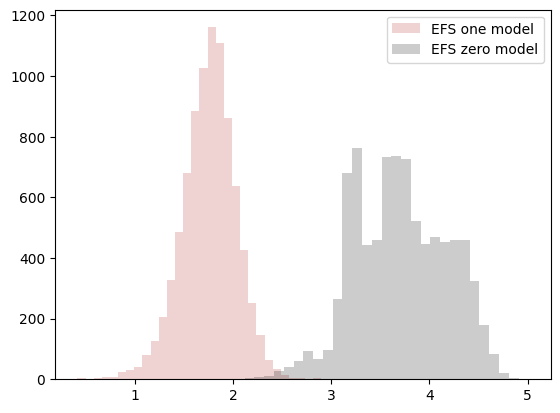

In [ ]:
dtesting_features=xgb.DMatrix(testing_features_df)
efs_zero_model_predictions=models['EFS 0'].predict(dtesting_features)
efs_one_model_predictions=models['EFS 1'].predict(dtesting_features)

plt.hist(efs_one_model_predictions, bins=30, color='firebrick', label='EFS one model')
plt.hist(efs_zero_model_predictions, bins=30, color='black', label='EFS zero model')
plt.legend(loc='best')
plt.show()

### 3.4. Prediction ratio distribution

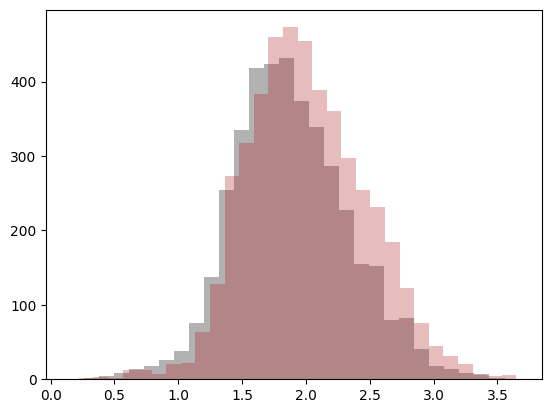

In [32]:
testing_labels=data_dict['Testing labels'].copy()
score=(efs_zero_model_predictions-efs_one_model_predictions)
testing_labels['regression_ratio']=score

efs_zero=testing_labels[testing_labels['efs'] == 0]
efs_one=testing_labels[testing_labels['efs'] == 1]

plt.hist(efs_zero['regression_ratio'], bins=30, alpha=0.3, color='black', label='EFS 0')
plt.hist(efs_one['regression_ratio'], bins=30, alpha=0.3, color='firebrick', label='EFS 1')
plt.show()